In [1]:
%matplotlib notebook
import numpy
import scipy
import scipy.interpolate

import copy
import os.path

import cPickle as pkl

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [136]:
import plotly.plotly as py
from plotly.graph_objs import *

import networkx as nx

ImportError: No module named plotly

In [2]:
import multiprocessing

In [3]:
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.colors as colors

In [4]:
filename = 'grs1915_all_125ms.dat'

In [40]:
data_original = numpy.load(filename)
data = data_original

In [41]:
new_data = [(dd[0][:,1:], dd[1]) for dd in data]
data = new_data

In [42]:
n_samples = len(data)
print '# of samples:', n_samples

# of samples: 2829


In [43]:
labelled = [dd[1] is not None for dd in data]
print '# of labelled samples:', numpy.sum(labelled)

# of labelled samples: 426


There are many missing values in the observation, which are marked as NaN. For this notebook, we simply replace those NaN's by a simple linear interpolation.

In [44]:
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = numpy.arange(A.shape[0])
    good = numpy.where(numpy.isfinite(A))
    f = scipy.interpolate.interp1d(inds[good], A[good],bounds_error=False, fill_value='extrapolate')
    B = numpy.where(numpy.isfinite(A),A,f(inds))
    return B

In [45]:
# replace NaN with 0's for now.
data_original = copy.deepcopy(data)
data = [None] * n_samples
for idx, dd in enumerate(data_original):
    x = dd[0]
    if x.shape[0] > 2:
        y = 0. * x
        for ii in xrange(x.shape[1]):
            y[:, ii] = fill_nan(x[:,ii])
        if numpy.sum(numpy.isnan(y)) > 0:
            print 'problem at ', idx
            break
    else:
        y = x
    data[idx] = (y, dd[1])

Okay, now this is a tricky part. I want to normalize the time series, but what is the correct way to do so? For now, I'm simply normalizing each time series separately to be zero-mean and unit-variance.

In [46]:
# simple normalization
data_n = [None] * n_samples
for idx, dd in enumerate(data):
    m = dd[0].mean(axis=0)
    s = dd[0].std(axis=0)
    dn = (dd[0] - m)/numpy.max(s, 1e-8)
    data_n[idx] = (dn, dd[1])

<IPython.core.display.Javascript object>


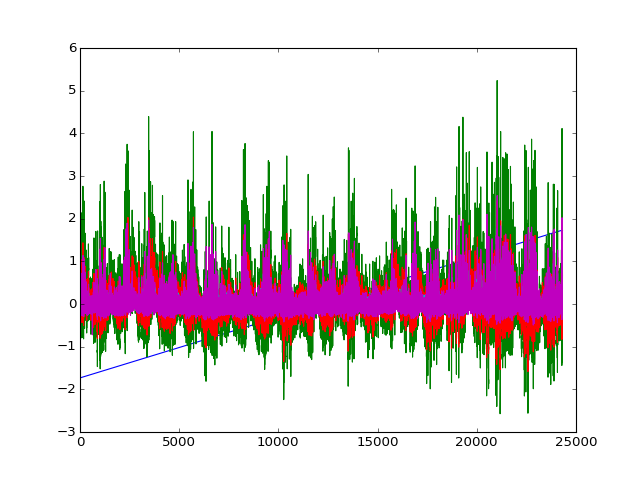

In [11]:
idx = 10

plot.hold('on')
for varidx in xrange(data_n[idx][0].shape[1]):
    plot.plot(data_n[idx][0][:,varidx])
plot.hold('off')
plot.show()

Well, it's a time series with varying number of steps. Let's try Fourier transform to convert each timeseries into a fixed-length representation here.

In [11]:
def do_fft(dd):
    fftc = numpy.fft.fft(dd[0], axis=0)
    return (fftc, dd[1])

In [47]:
if os.path.exists(filename+'.fft.npy'):
    fft_coeffs = numpy.load(filename+'.fft.npy')
    fft_coeffs = [(ff[0][:,1:], ff[1]) for ff in fft_coeffs]
else:
    pool = multiprocessing.Pool(6)
    fft_coeffs = pool.map(do_fft, data)
    numpy.save(filename+'.fft', fft_coeffs)

In [49]:
fft_coeffs[0][0].shape

(11903, 4)

In [13]:
band_max=1000

<IPython.core.display.Javascript object>


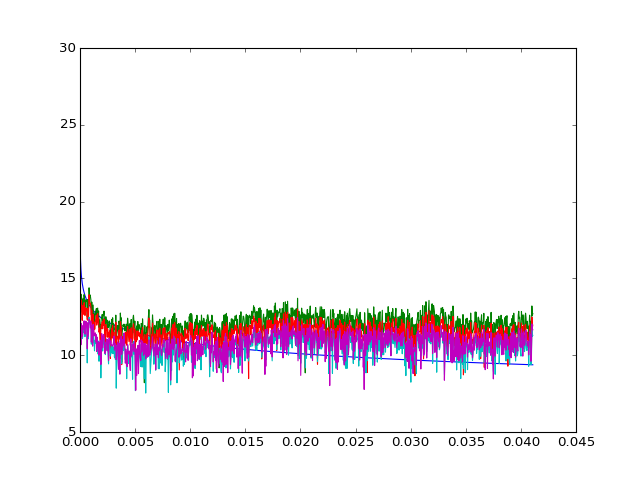

In [15]:
idx = 10

plot.figure()
plot.hold('on')
for varidx in xrange(fft_coeffs[idx][0].shape[1]):
    ll = fft_coeffs[idx][0].shape[0]
    coeff = fft_coeffs[idx][0][:,varidx]
    freq = numpy.fft.fftfreq(len(coeff))
    plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
plot.hold('off')
plot.show()

In [50]:
fft_coeffs_filt = [(numpy.absolute(dd[0][:band_max,:]), dd[1]) for dd in fft_coeffs]
for idx, dd in enumerate(fft_coeffs_filt):
    if numpy.sum(numpy.isnan(dd[0])) > 0:
        print 'NaN detected at', idx
        break
    dd[0].resize(band_max, dd[0].shape[1])

In [51]:
fft_features = numpy.vstack([dd[0].flatten() for dd in fft_coeffs_filt])

Let's project the FFT-based features down to 2-D using PCA+tSNE.

In [52]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=50)
Y_pca = pca_model.fit_transform(fft_features)

In [55]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
Y_tsne = model.fit_transform(Y_pca)

In [56]:
labels = numpy.unique([dd[1] for dd in data_original])
label_dict = dict([(dd,ii) for ii, dd in enumerate(labels)])

<IPython.core.display.Javascript object>


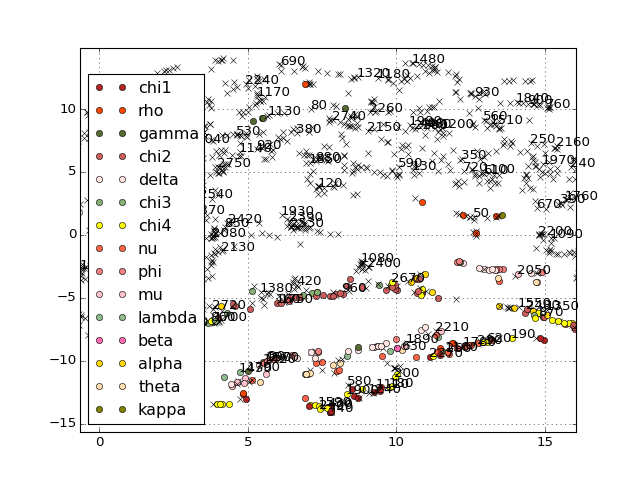

In [59]:
plot.figure()
clist = colors.cnames.values()

Y = Y_tsne
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
        plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
    if numpy.mod(idx, every) == 0:
        plot.annotate(xy=(Y[idx,0], Y[idx,1]), s=idx)

plot.hold('off')
plot.legend(legend_handles, legends, loc="lower left")
plot.grid('on')

plot.show()

If there are any interesting timeseries found from the figure above, let's draw them here.

<IPython.core.display.Javascript object>


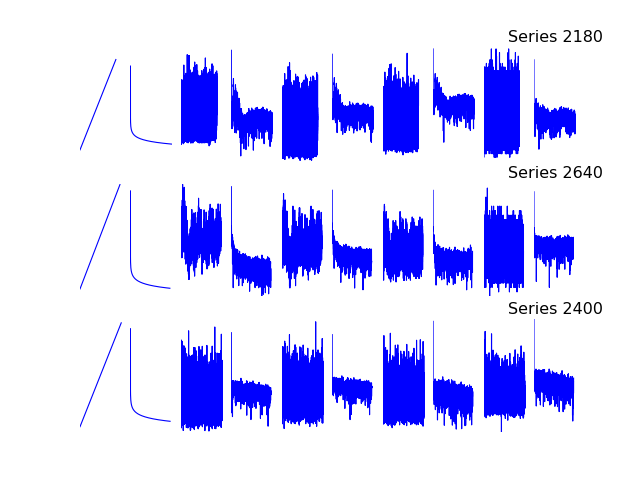

In [25]:
interesting = [2180, 2640, 2400]
band_max=1000

plot.figure()
for idx, ii in enumerate(interesting):
    series = data_original[ii][0]
    for sidx in xrange(series.shape[1]):
        plot.subplot(len(interesting), 4*2, idx*(4*2)+(2*sidx)+1)
        plot.plot(series[:,sidx])
        plot.axis('off')
        
        plot.subplot(len(interesting), 4*2, idx*(4*2)+(2*sidx)+2)
        ll = fft_coeffs[ii][0].shape[0]
        coeff = fft_coeffs[ii][0][:,sidx]
        freq = numpy.fft.fftfreq(len(coeff))
        plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
        plot.axis('off')
    plot.title('Series %d'%ii)


Let's try a deep autoencoder. We'll work on the PCA'd fourier features. We're using Theano, so install theano by ``pip install --user theano``

In [20]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams

from collections import OrderedDict

In [21]:
def rmsprop(tparams, grads, inps, cost):
    zipped_grads = [theano.shared(p.get_value() * numpy.float32(0.), 
                                  name='%s_grad'%k) 
                    for k, p in tparams.iteritems()]
    running_grads = [theano.shared(p.get_value() * numpy.float32(0.), 
                                   name='%s_rgrad'%k) 
                     for k, p in tparams.iteritems()]
    running_grads2 = [theano.shared(p.get_value() * numpy.float32(0.), 
                                    name='%s_rgrad2'%k) 
                      for k, p in tparams.iteritems()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rgup = [(rg, numpy.float32(0.95) * rg + numpy.float32(0.05) * g) 
            for rg, g in zip(running_grads, grads)]
    rg2up = [(rg2, numpy.float32(0.95) * rg2 + numpy.float32(0.05) * (g ** 2)) 
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function(inps, cost, updates=zgup+rgup+rg2up)

    updir = [theano.shared(p.get_value() * numpy.float32(0.), name='%s_updir'%k) 
             for k, p in tparams.iteritems()]
    updir_new = [(ud, numpy.float32(0.9) * ud - 
                      numpy.float32(1e-4) * zg / 
                      tensor.sqrt(rg2 - rg ** 2 + numpy.float32(1e-4))) 
                 for ud, zg, rg, rg2 
                 in zip(updir, zipped_grads, running_grads, running_grads2)]
    param_up = [(p, p + udn[1]) for p, udn 
                in zip(tparams.values(), updir_new)]
    f_update = theano.function([], [], 
                               updates=updir_new+param_up, 
                               on_unused_input='ignore')

    return f_grad_shared, f_update

In [64]:
train_set = copy.copy(fft_features)
m_train = train_set.mean(0)
s_train = train_set.std(0)
train_set = (train_set - m_train) / numpy.maximum(1e-8, s_train)

In [65]:
# build a 2-layer autoencoder
h_dim = 100
z_dim = 2

noisy = theano.shared(numpy.float32(0.))
rng = MRG_RandomStreams(1234)

W = theano.shared(numpy.float32(numpy.random.randn(train_set.shape[1], h_dim)))
b = theano.shared(numpy.float32(numpy.zeros((h_dim,))))
W1 = theano.shared(numpy.float32(numpy.random.randn(h_dim, h_dim)))
b1 = theano.shared(numpy.float32(numpy.zeros((h_dim,))))
U = theano.shared(numpy.float32(numpy.random.randn(h_dim, z_dim)))
c = theano.shared(numpy.float32(numpy.zeros((z_dim,))))
bx = theano.shared(numpy.float32(numpy.zeros((train_set.shape[1],))))
tparams = OrderedDict([('W', W), ('b', b), 
                       ('W1', W1), ('b1', b1), 
                       ('U', U), ('c', c), 
                       ('bx', bx)])

x = tensor.matrix(dtype='float32')
x_ = x + noisy * numpy.float32(0.1) * rng.normal(x.shape, dtype='float32')
h_pre = tensor.dot(x_, W) + b[None,:]
h_post = tensor.tanh(h_pre)

h_pre = tensor.dot(h_post, W1) + b1[None,:]
h_post = tensor.tanh(h_pre)

z_pre = tensor.dot(h_post, U) + c[None, :]
z_post = z_pre

hr_pre = tensor.dot(z_post, U.T) + b[None, :]
hr_post = tensor.tanh(hr_pre)

hr_pre = tensor.dot(hr_post, W1.T) + b1[None, :]
hr_post = tensor.tanh(hr_pre)

xr = tensor.dot(hr_post, W.T) + bx[None, :]

f_proj = theano.function([x], z_post)

cost = (tensor.abs_(x - xr)).sum(-1).mean()

grads = tensor.grad(cost, wrt=tparams.values())
f_grad_shared, f_update = rmsprop(tparams, grads, [x], cost)


In [66]:
for k, v in tparams.iteritems():
    shp = v.get_value().shape
    v.set_value(0.01 * numpy.float32(numpy.random.randn(*shp)))

In [23]:
if os.path.exists(filename+'.as.npz'):
    sparams = numpy.load(filename+'.ae.npz')
    for k, v in sparams.iteritems():
        tparams[k].set_value(v)

In [123]:
mbsz = 128
n_epochs = 15000

uidx = 0
mov_cost = None
every = 50
for epidx in xrange(n_epochs):
    numpy.random.permutation(train_set)
    noisy.set_value(1.)
    for mbidx in xrange(int(numpy.ceil(numpy.float(n_samples) / mbsz))):
        mb = train_set[mbidx*mbsz:(mbidx+1)*mbsz,:]
        cc = f_grad_shared(mb.astype('float32'))
        f_update()
        uidx += 1
        if mov_cost is None:
            mov_cost = cc
        else:
            mov_cost = 0.95 * mov_cost  + 0.05 * cc
    if numpy.mod(epidx, every) == 0:
        print 'Epoch', (epidx+1), 'Cost', mov_cost
noisy.set_value(0.)

Epoch 1 Cost 1309.48200017
Epoch 51 Cost 1289.12147333
Epoch 101 Cost 1286.64039428
Epoch 151 Cost 1283.17964023
Epoch 201 Cost 1281.74017278
Epoch 251 Cost 1277.9799001
Epoch 301 Cost 1276.83035008
Epoch 351 Cost 1276.91142907
Epoch 401 Cost 1275.46610521
Epoch 451 Cost 1271.94503556
Epoch 501 Cost 1271.42592206
Epoch 551 Cost 1273.30916682
Epoch 601 Cost 1269.44061188
Epoch 651 Cost 1269.2774139
Epoch 701 Cost 1269.17404873
Epoch 751 Cost 1267.23025691
Epoch 801 Cost 1267.73874156
Epoch 851 Cost 1264.97937999
Epoch 901 Cost 1264.83742526
Epoch 951 Cost 1265.95635218
Epoch 1001 Cost 1265.18657379
Epoch 1051 Cost 1267.65495581
Epoch 1101 Cost 1265.97917199
Epoch 1151 Cost 1261.28880338
Epoch 1201 Cost 1259.47537578
Epoch 1251 Cost 1263.02773744
Epoch 1301 Cost 1260.31833014
Epoch 1351 Cost 1259.83840792
Epoch 1401 Cost 1257.7179652
Epoch 1451 Cost 1259.09841789
Epoch 1501 Cost 1255.95311844
Epoch 1551 Cost 1253.91202277
Epoch 1601 Cost 1256.60051121
Epoch 1651 Cost 1256.03718192
Epoch 

KeyboardInterrupt: 

In [124]:
sparams = dict([(k,v.get_value()) for k, v in tparams.iteritems()])
numpy.savez(filename+'.ae.npz', **sparams)

In [125]:
Y_ae =f_proj(train_set.astype('float32'))
ae_white = PCA(n_components=2, whiten=True)
Y_ae_pca = ae_white.fit_transform(Y_ae)

In [126]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
Y_ae_tsne = model.fit_transform(Y_ae_pca)

<IPython.core.display.Javascript object>


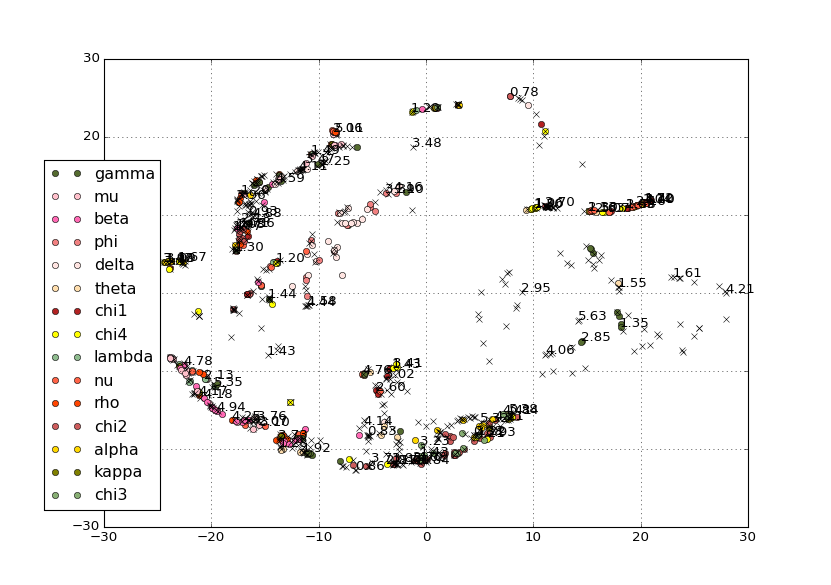

In [127]:
plot.figure()
clist = colors.cnames.values()

Y = Y_ae_tsne
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

viz_range = [0, 1000]

every=10
for ii in xrange(viz_range[0], viz_range[1]): #xrange(Y.shape[0]):
    idx = time_sorted_idx[ii]
    if data_original[idx][1] is None:
        plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
    if numpy.mod(idx, every) == 0:
        plot.annotate(xy=(Y[idx,0], Y[idx,1]), s="%1.2f"%(timestamps[ii]/10e7))

plot.hold('off')
plot.legend(legend_handles, legends, bbox_to_anchor=(0.1,0.8))
plot.grid('on')

plot.show()

<IPython.core.display.Javascript object>


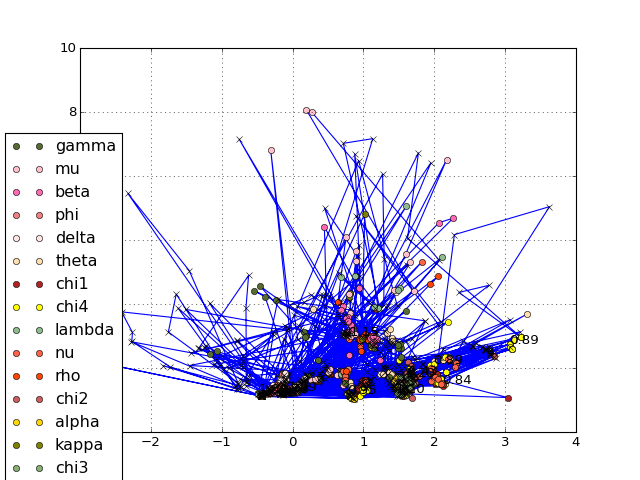

In [130]:
plot.figure()
clist = colors.cnames.values()

Y = Y_ae_tsne
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

viz_range = [0, 1000]

every=100

Y_sorted = Y[time_sorted_idx, :]
sorted_viz_range = [time_sorted_idx[ii] for ii in xrange(viz_range[0], viz_range[1])]
plot.plot(Y[sorted_viz_range,0], Y[sorted_viz_range,1])
#plot.quiver(Y_sorted[viz_range[0]:viz_range[1],0], Y_sorted[viz_range[0]:viz_range[1],1], 
#           Y_sorted[viz_range[0]+1:viz_range[1],0]-Y_sorted[viz_range[0]:viz_range[1]-1,0], 
#           Y_sorted[viz_range[0]+1:viz_range[1],1]-Y_sorted[viz_range[0]:viz_range[1]-1,1], 
#           scale_units='xy', angles='xy', scale=1)

for ii in xrange(viz_range[0], viz_range[1]): #xrange(Y.shape[0]):
    idx = time_sorted_idx[ii]
    if data_original[idx][1] is None:
        plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
    if numpy.mod(idx, every) == 0:
        plot.annotate(xy=(Y[idx,0], Y[idx,1]), s="%1.2f"%(timestamps[idx]/10e7))

plot.hold('off')
plot.legend(legend_handles, legends, bbox_to_anchor=(0.1,0.8))
plot.grid('on')

plot.show()

In [113]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(['g']*gmm.means_.shape[0]):
        v, w = numpy.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / numpy.linalg.norm(w[0])
        angle = numpy.arctan2(u[1], u[0])
        angle = 180 * angle / numpy.pi  # convert to degrees
        v *= 9
        ell = matplotlib.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                         180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)

In [114]:
from sklearn import mixture

g = mixture.GMM(n_components=12, n_init=10, covariance_type='full')
GM = g.fit(Y_ae_tsne)

<IPython.core.display.Javascript object>


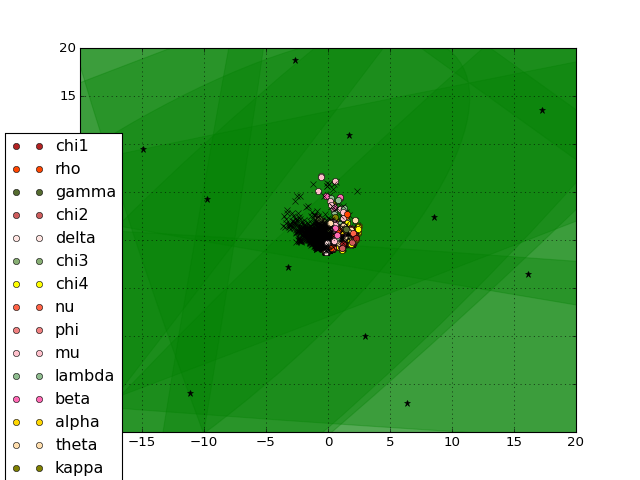

In [115]:
plot.figure()
clist = colors.cnames.values()

Y = Y_ae_pca
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
        plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
        #if numpy.mod(idx, every) == 0:
        #    plot.annotate(xy=(Y[idx,0], Y[idx,1]), s=idx)
ax = plot.gca()
make_ellipses(GM, ax)
for idx in xrange(GM.means_.shape[0]):
    f, = plot.plot(GM.means_[idx,0], GM.means_[idx,1], 'k*')
    

plot.hold('off')
plot.legend(legend_handles, legends, bbox_to_anchor=(0.1,0.8))
plot.grid('on')

plot.show()

In [116]:
from sklearn.cluster import KMeans

In [131]:
k = KMeans(n_clusters=20)
KM = k.fit_transform(Y_ae_tsne)

In [132]:
assignments = KM.argmin(-1)

In [133]:
assignments

array([ 4,  1, 11, ..., 10,  0, 14])

<IPython.core.display.Javascript object>


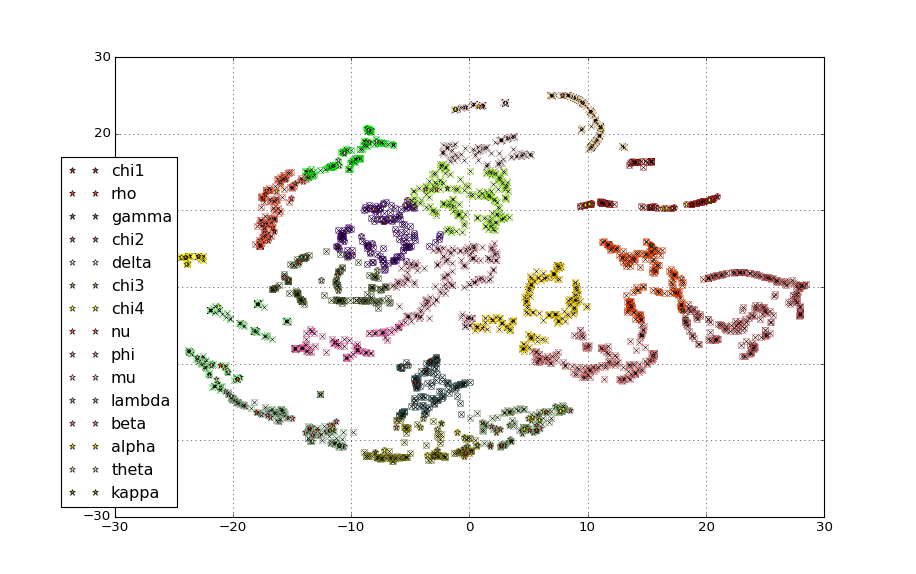

In [134]:
plot.figure()
clist = colors.cnames.values()

Y = Y_ae_tsne
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
        plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], '*', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
    plot.plot(Y[idx,0], Y[idx,1], 'o', markeredgecolor=clist[assignments[idx]],
             markerfacecolor='None')    

plot.hold('off')
plot.legend(legend_handles, legends, bbox_to_anchor=(0.1,0.8))
plot.grid('on')

plot.show()

In [74]:
Y_ae_pca.shape

(2829, 2)

In [79]:
orig = numpy.load(filename)

In [81]:
orig[0][0][:,0]

array([  4.67724096e+08,   4.67724096e+08,   4.67724096e+08, ...,
         4.67725584e+08,   4.67725584e+08,   4.67725584e+08])

In [82]:
orig[1][0][:,0]

array([  2.01846369e+08,   2.01846369e+08,   2.01846369e+08, ...,
         2.01847488e+08,   2.01847488e+08,   2.01847488e+08])

In [84]:
orig[100][0][0,0]

373099998.93760204

In [85]:
timestamps = [dd[0][0,0] for dd in orig]

In [87]:
time_sorted_idx = numpy.argsort(timestamps)